# Part 2: US Flight Data 

### Question (a): What are the best times and days of the week to minimise delays each year?

#### Importing Libraries and Datasets

We will be importing the following libraries for our subsequent data analysis. Pandas will be used to explore our datasets, and includes functions that analyse, manipulate and clean our dataframe. Numpy allows us to perform operations on arrays. Seaborn and Matplotlib gives us the tools for visualising our data. 

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Subsequently we will be reading in our 10-year dataset.

In [2]:
df95 = pd.read_csv("1995 copy.csv")
df96 = pd.read_csv("1996 copy.csv")
df97 = pd.read_csv("1997 copy.csv")
df98 = pd.read_csv("1998 copy.csv")
df99 = pd.read_csv("1999 copy.csv")
df00 = pd.read_csv("2000 copy.csv")
df01 = pd.read_csv("2001 copy.csv",encoding ='ISO-8859-1')
df02 = pd.read_csv("2002 copy.csv",encoding ='ISO-8859-1')
df03 = pd.read_csv("2003 copy.csv")
df04 = pd.read_csv("2004 copy.csv")
df05 = pd.read_csv("2005 copy.csv")

/var/folders/45/ldf1k87x277414bmf2l5slpr0000gn/T/ipykernel_16367/4093503801.py:9: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df03 = pd.read_csv("2003 copy.csv")


#### Defining Delay

Upon inspection of our dataset, we realise that delay is broken into 2 types of delay, arrival delay `ArrDelay` and departure delay `DepDelay`. To overcome this, we will be combining the ArrDelay and DepDelay into a new variable column, `TotalDelay`. Using `min()` and `max()` methods, we are able to see the range of TotalDelay for our given dataset. Note that within `ArrDelay` and `DepDelay` there are negative delays; indicative of a flight arriving or departing earlier than scheduled. Therefore we should remove these values as they will not be helpful in our exploration. We create a function `compute_NegDelay` that converts negative delay values which indicate that the flight arrived/departed early into 0. This cleans our dataset by only showing "bad" delays instead of both "bad and "good" delays. 

#### Selecting Relevant Variables - Best Time of the Day

Before any analysis can be done, ideally we would like to filter out variables from our dataframe. This is done in order to reduce computational load on our devices, while at the same time showcasing our insights more effectively. 
Our chosen variables will include: `DepDelay`,`ArrDelay`,`DepTime` and created variable `TotalDelay`. To reduce redundancy of data, we will focus our efforts on flights leaving their respective airports and as such we will not be including `ArrTime` nor looking at flight information for planes arriving at their destination.

On `Cancelled` and `Diverted` variables, upon further inspection, we see that the percentage of cancelled flights (2%) as well as diverted flights (0.2%) is extremely small compared to total flights and as a result we will not be factoring those types of flights into our analysis. 

For every yearly dataset, this will be the breakdown as to what we will be looking to do to the data:

Firstly we will be ***Pre-processing*** - selecting our variables, handling `NaN` values, delay values. 

Then we will move on the ***Analysis*** step - creating bins for the 2-hour time intervals we will be using and grouping the departure times into a new column. This is so we are able to visualise percentage of flights departing per time interval and subsequently the average time delay for flights in said time intervals. 

Finally, we then move on the ***Conclusion*** step, where we derive insights from our visualisation. 

Our pipeline for deriving the best times of the week to fly is as follows: 

   1. Run `cleaner` function which removes rows with `NaN` values and converts `float64` datatypes to `int64`.
   
   2. Run `compute_NegDelay` function to convert negative delay values to 0.
   
   3. Run `compute_TotalDelay` function which sums up ArrDelay and DepDelay and returns a new column TotalDelay.
   
   4. Run `create_interval` function that breaks down 24 hours into 2-hour intervals which groups DepTime. 
   
   5. Run `calculate_mean_delay` function which determines the mean delay in each interval.
   
   6. Run `visualize_delay` to showcase our findings in a histplot and barplot.
   

In [74]:
def cleaner(df):
    cleaned_df = df.loc[:, ['DepTime', 'DepDelay', 'ArrDelay']]
    
#     print("Number of missing values:")
#     print(cleaned_df.isnull().sum())
    cleaned_df.dropna(inplace=True)
    
    float_columns = cleaned_df.select_dtypes(include=['float64']).columns
    cleaned_df[float_columns] = cleaned_df[float_columns].astype(int)
    
    return cleaned_df

In [75]:
def convert_NegDelay(df, column1, column2):
    df[column1] = np.maximum(df[column1], 0)
    df[column2] = np.maximum(df[column2], 0)
    
    return df

In [76]:
def compute_TotalDelay(df):
    if df is None or 'ArrDelay' not in df.columns or 'DepDelay' not in df.columns:
        raise ValueError("Invalid DataFrame: 'ArrDelay' or 'DepDelay' column is missing.")
    
    arr_delay = df['ArrDelay'].fillna(0)
    dep_delay = df['DepDelay'].fillna(0)
    
    delay_values = arr_delay + dep_delay
    df['TotalDelay'] = delay_values
    
    return df

In [77]:
def create_interval(df, time_column='DepTime'):
    bins = [0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400]
    labels = ['0000-0200', '0200-0400', '0400-0600', '0600-0800', '0800-1000', '1000-1200',
              '1200-1400', '1400-1600', '1600-1800', '1800-2000', '2000-2200', '2200-2400']
    
    df['TimeInterval'] = pd.cut(df[time_column], bins=bins, labels=labels, include_lowest=True)
    
    return df

In [78]:
def calculate_mean_delay(df):
    mean_delay = df.groupby('TimeInterval')['TotalDelay'].mean().reset_index()
    
    return mean_delay

In [100]:
def visualize_delay(df, mean_delay):
    max_delay = mean_delay['TotalDelay'].max()
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 8)) 
    
    sns.histplot(df, x='TimeInterval', stat='percent', legend=False, discrete=True, ax=ax[0], hue='TimeInterval', palette='flare')
    ax[0].set_title('Percentage of DEPARTING flights / time interval')
    ax[0].tick_params(axis='x', rotation=45)
    ax[0].set_xlabel('Time interval', rotation=0)
    ax[0].set_ylabel('Percentage')

    sns.barplot(mean_delay, x='TimeInterval', y='TotalDelay', palette='crest', errorbar=None, ax=ax[1])
    ax[1].set_title('Average Delay by Time interval')
    ax[1].tick_params(axis='x', rotation=45)
    ax[1].set_yticks(range(0, int(max_delay), 10))
    ax[1].set_xlabel('Time interval', rotation=0)
    ax[1].set_ylabel('Average Delay (minutes)')
    
    sns.set_style("darkgrid")

    plt.show()

In [101]:
def print_top_delay_intervals(mean_delay):
    mean_delay_sorted = mean_delay.sort_values(by=['TotalDelay'], ascending=True)
    lowest_intervals = mean_delay_sorted.head(3)
    
    print("Top 3 Time Intervals with the Lowest Delay:")
    for index, row in lowest_intervals.iterrows():
        interval = row['TimeInterval']
        delay = row['TotalDelay']
        print(f"{index + 1}. {interval}: {delay:.2f} minutes")

Processing data for year 1995:


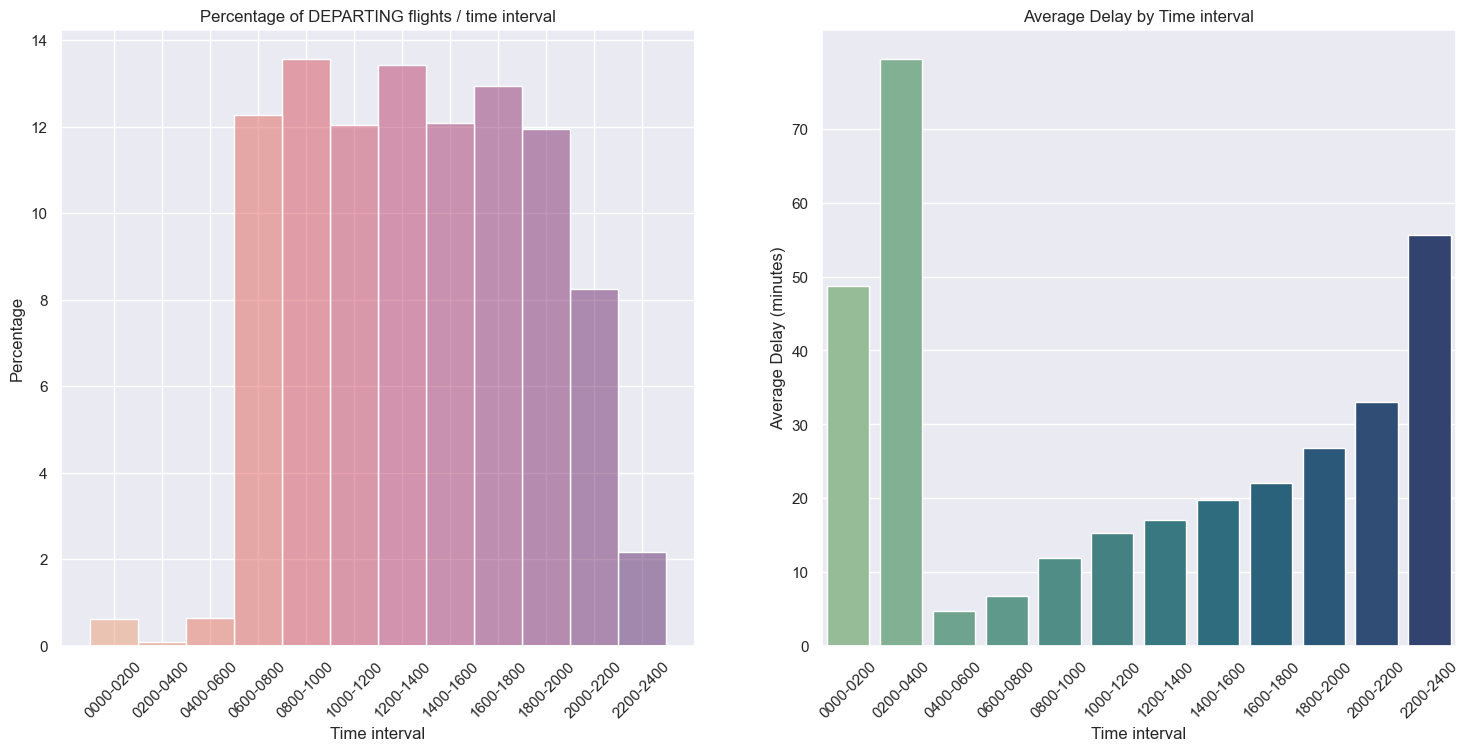

Top 3 Time Intervals with the Lowest Delay:
3. 0400-0600: 4.73 minutes
4. 0600-0800: 6.67 minutes
5. 0800-1000: 11.87 minutes
---
Processing data for year 1996:


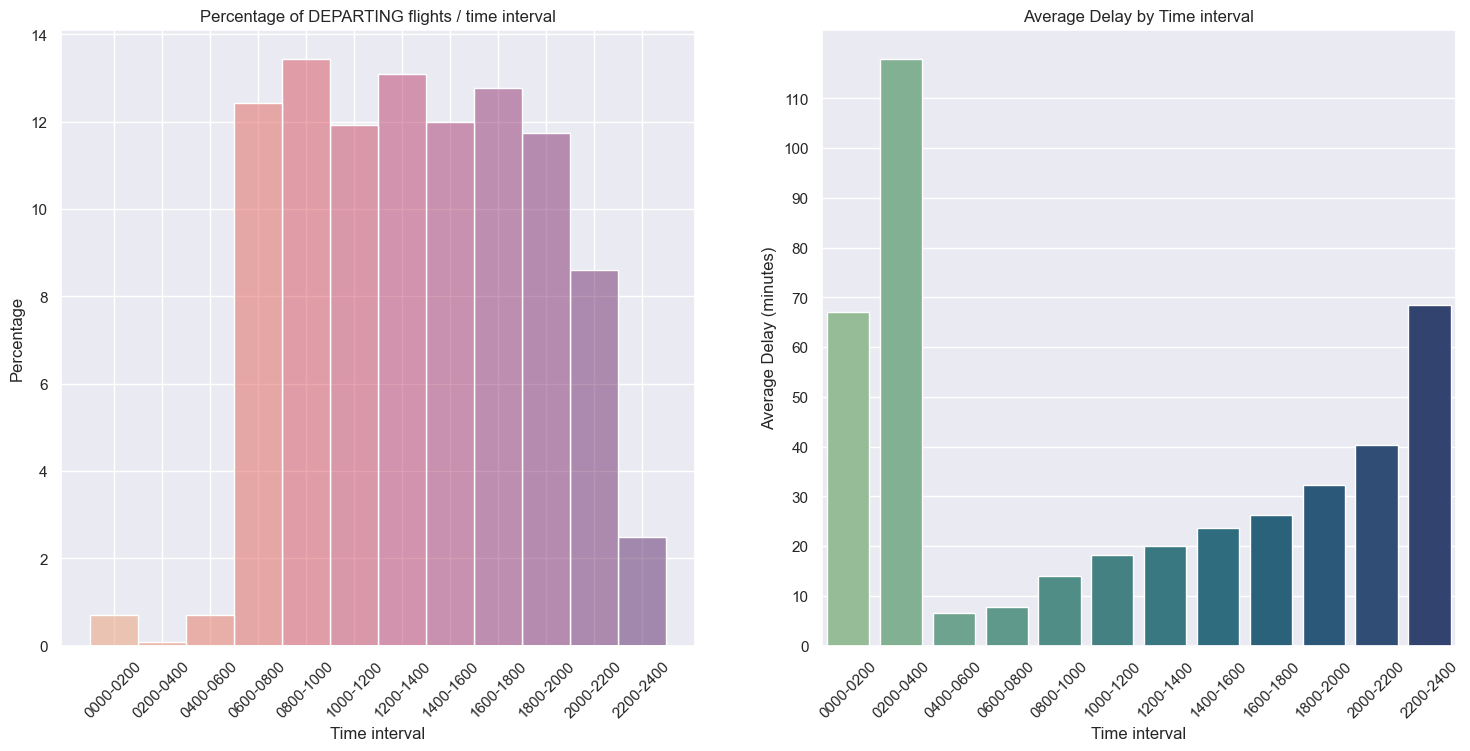

Top 3 Time Intervals with the Lowest Delay:
3. 0400-0600: 6.63 minutes
4. 0600-0800: 7.83 minutes
5. 0800-1000: 14.06 minutes
---
Processing data for year 1997:


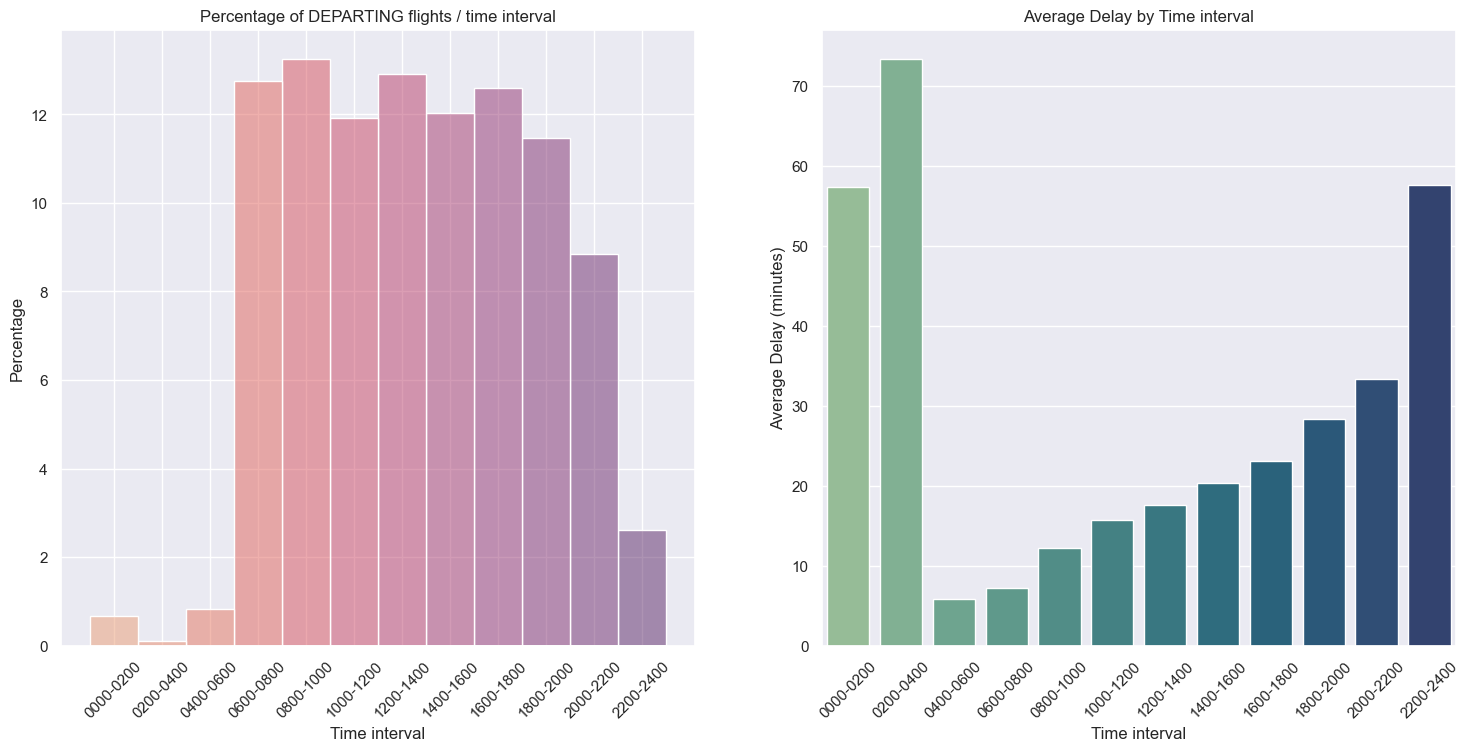

Top 3 Time Intervals with the Lowest Delay:
3. 0400-0600: 5.81 minutes
4. 0600-0800: 7.17 minutes
5. 0800-1000: 12.18 minutes
---
Processing data for year 1998:


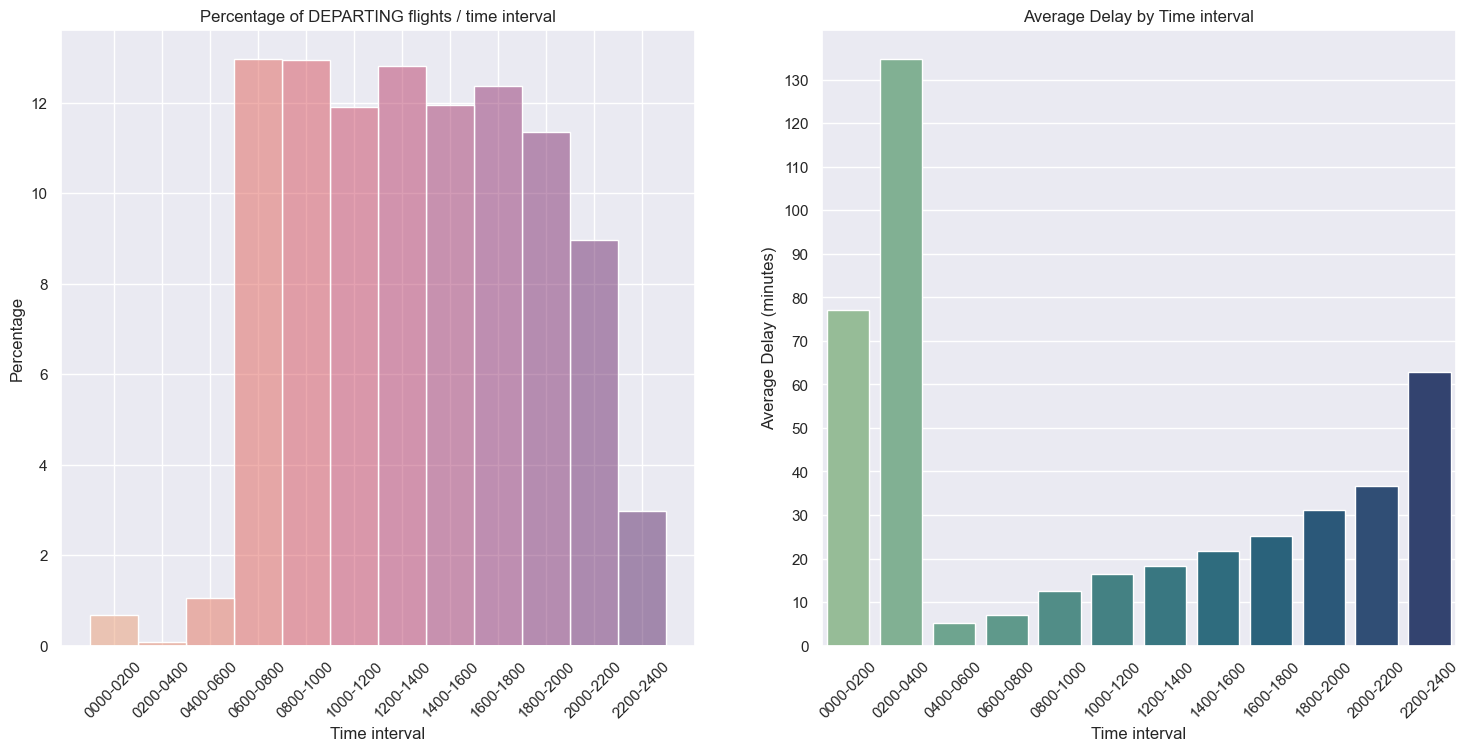

Top 3 Time Intervals with the Lowest Delay:
3. 0400-0600: 5.27 minutes
4. 0600-0800: 6.95 minutes
5. 0800-1000: 12.54 minutes
---
Processing data for year 1999:


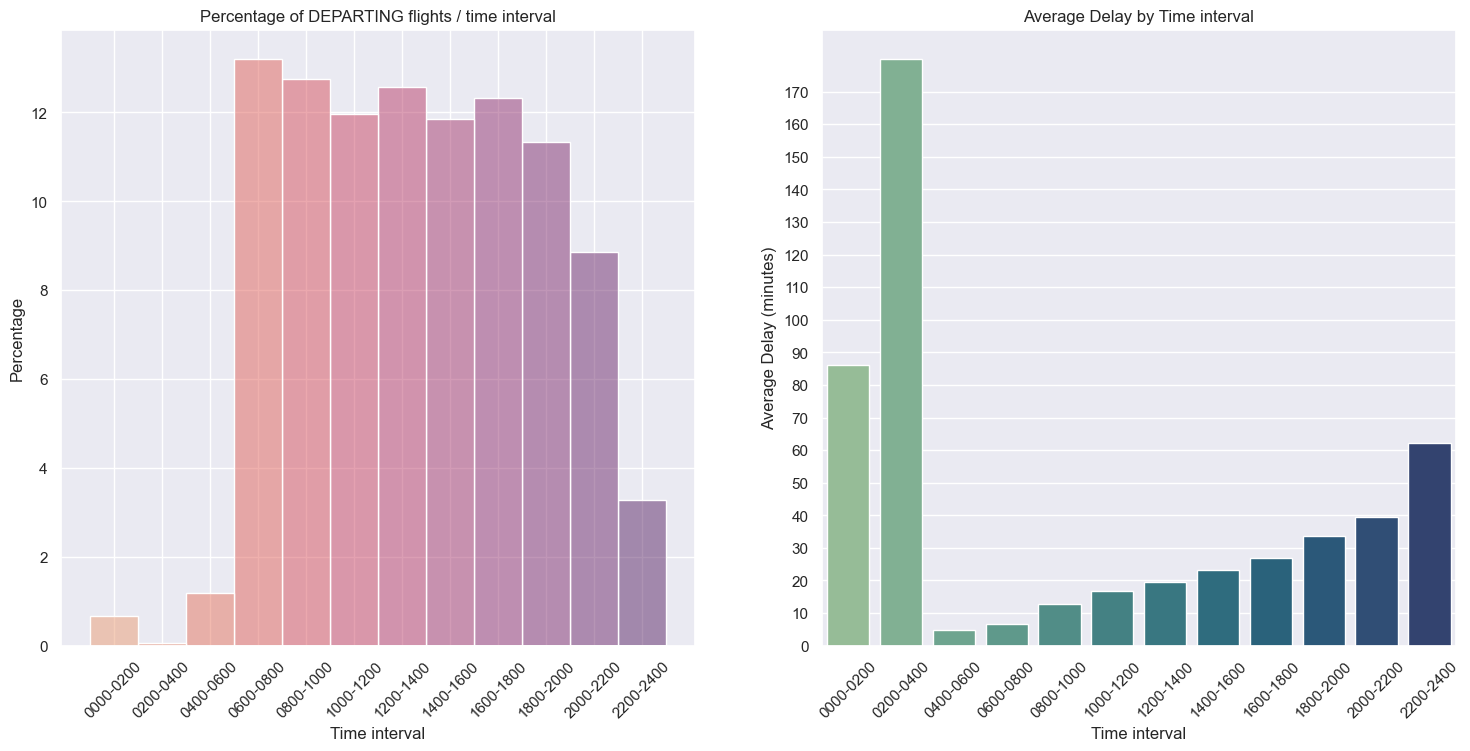

Top 3 Time Intervals with the Lowest Delay:
3. 0400-0600: 4.71 minutes
4. 0600-0800: 6.78 minutes
5. 0800-1000: 12.93 minutes
---
Processing data for year 2000:


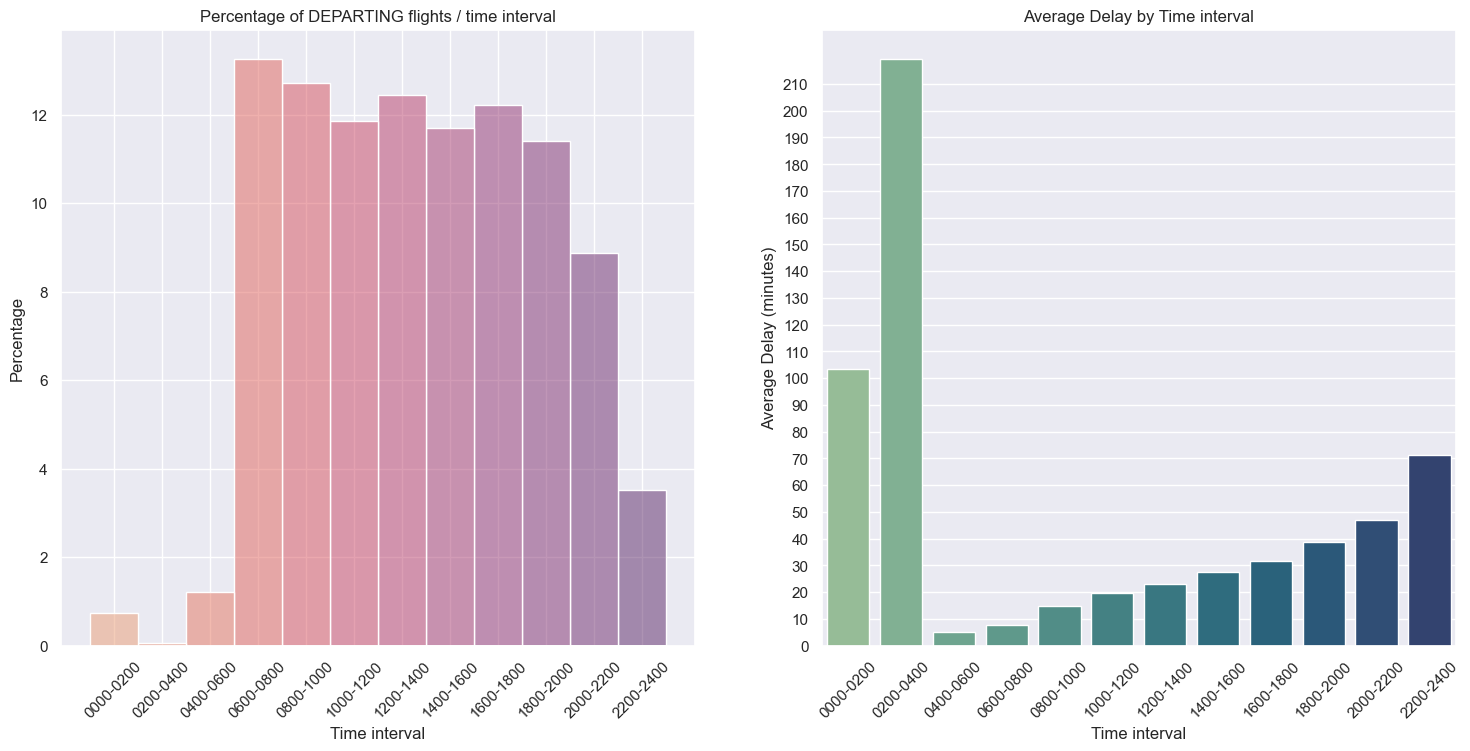

Top 3 Time Intervals with the Lowest Delay:
3. 0400-0600: 4.93 minutes
4. 0600-0800: 7.77 minutes
5. 0800-1000: 15.00 minutes
---
Processing data for year 2001:


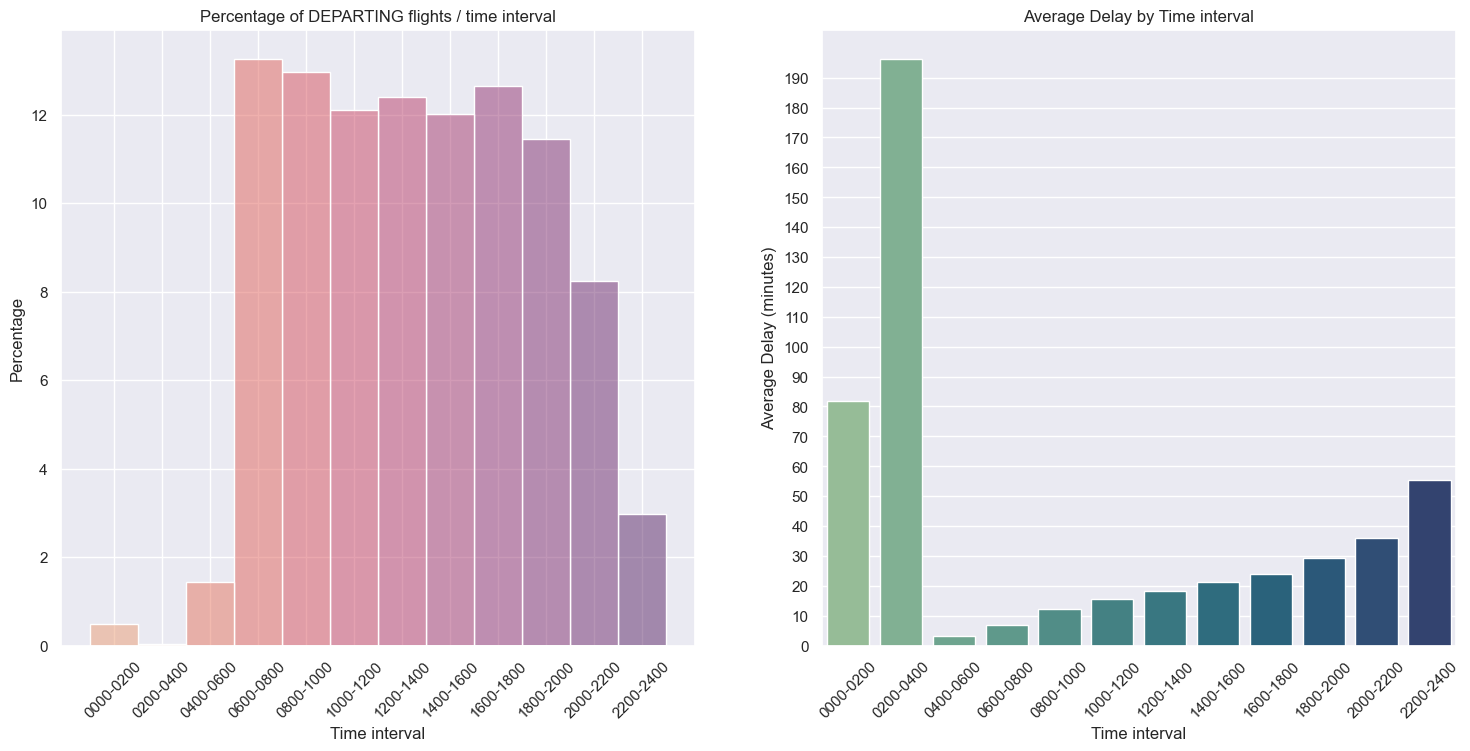

Top 3 Time Intervals with the Lowest Delay:
3. 0400-0600: 3.34 minutes
4. 0600-0800: 6.79 minutes
5. 0800-1000: 12.25 minutes
---
Processing data for year 2002:


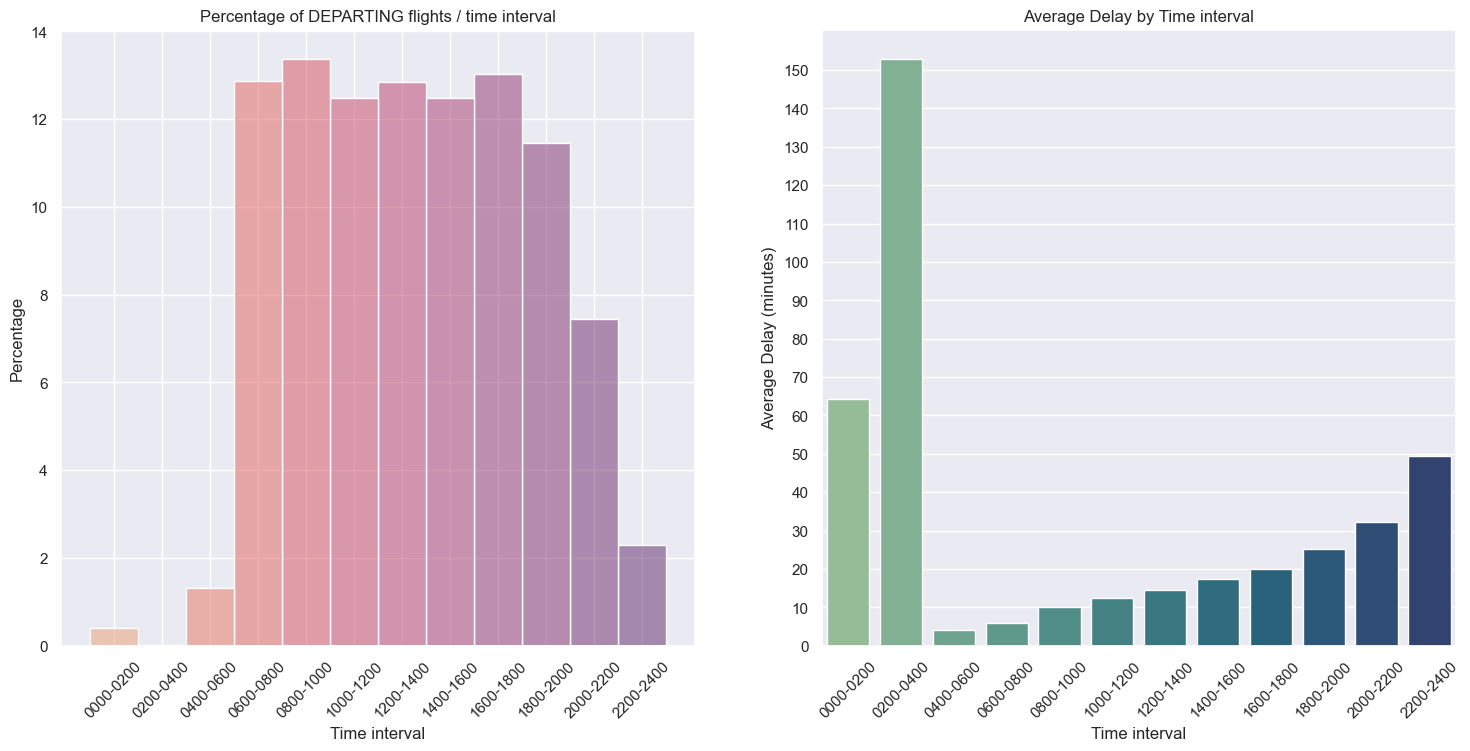

Top 3 Time Intervals with the Lowest Delay:
3. 0400-0600: 3.98 minutes
4. 0600-0800: 5.87 minutes
5. 0800-1000: 10.09 minutes
---
Processing data for year 2003:


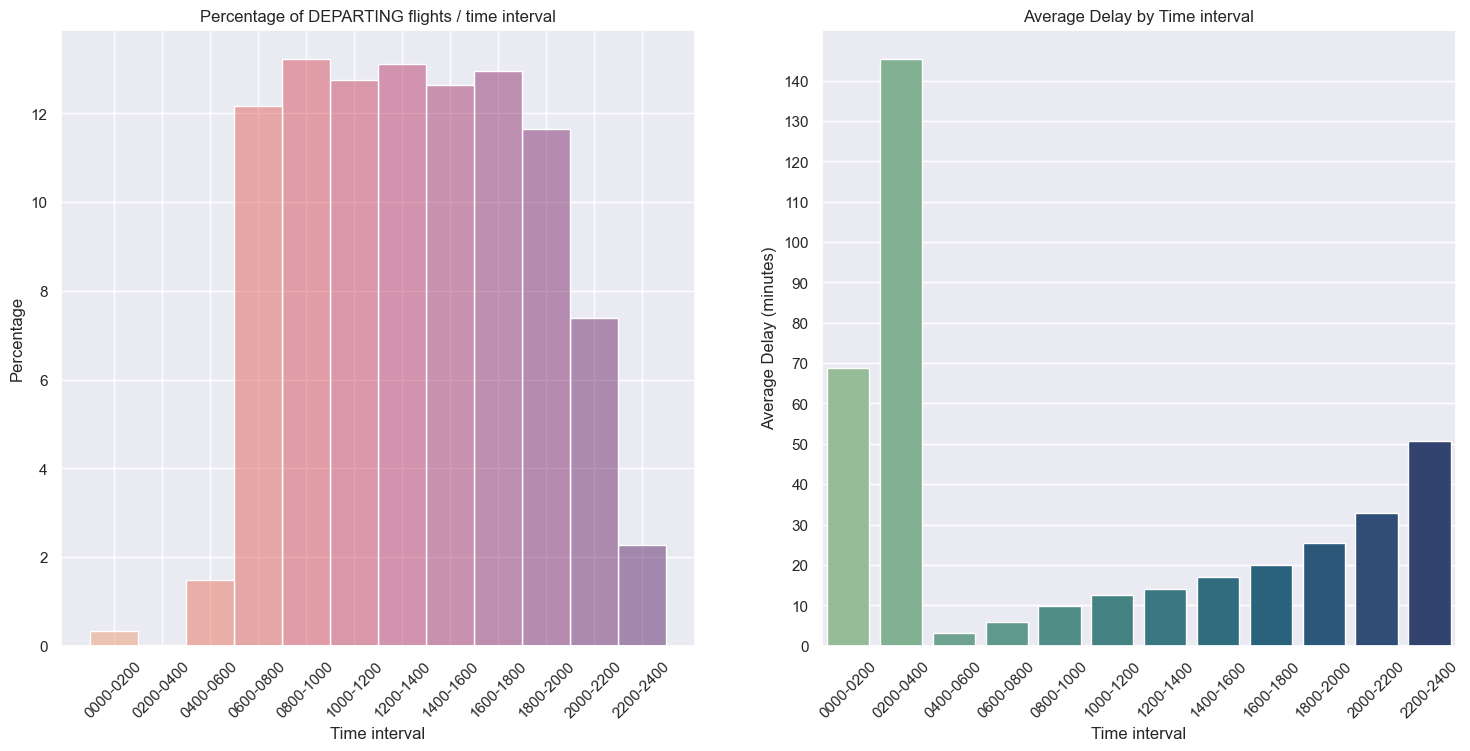

Top 3 Time Intervals with the Lowest Delay:
3. 0400-0600: 3.22 minutes
4. 0600-0800: 5.83 minutes
5. 0800-1000: 9.81 minutes
---
Processing data for year 2004:


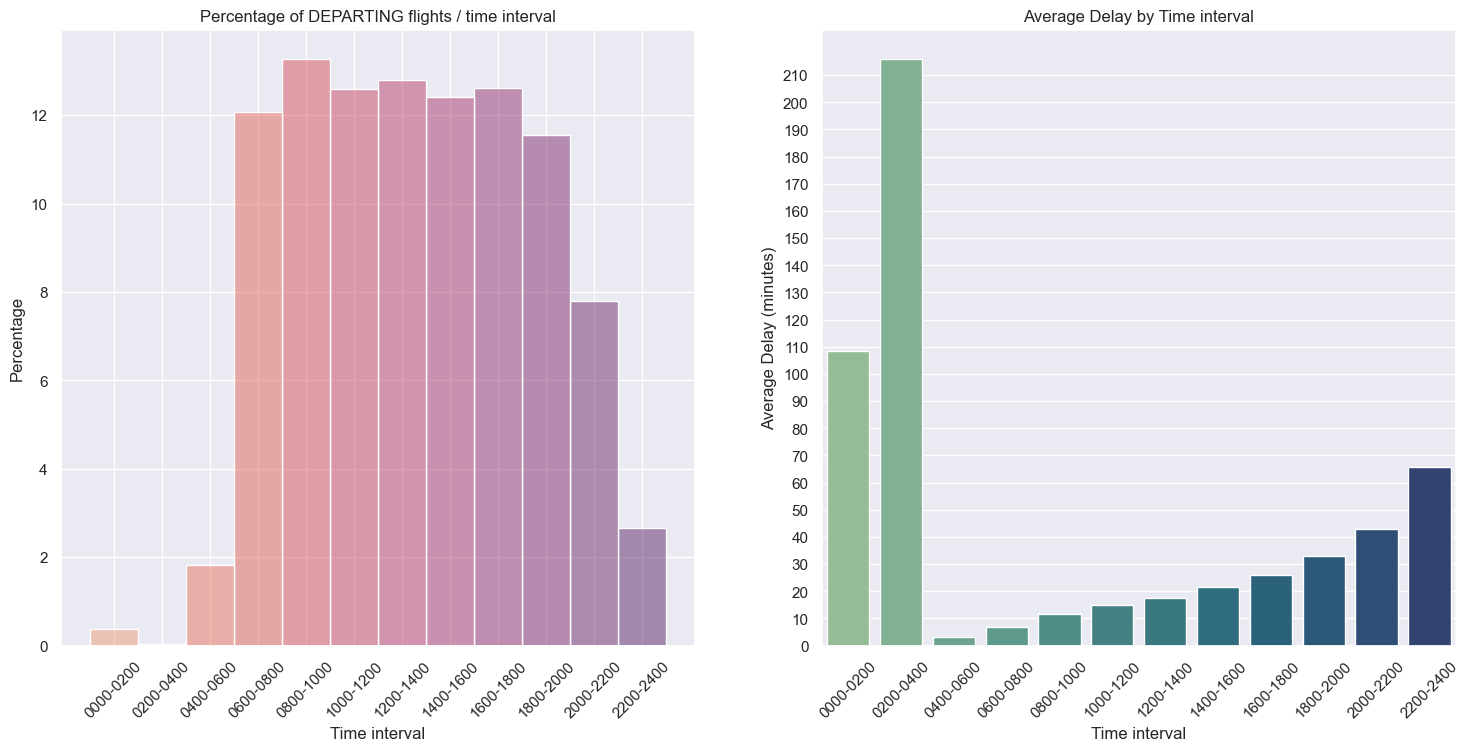

Top 3 Time Intervals with the Lowest Delay:
3. 0400-0600: 3.22 minutes
4. 0600-0800: 6.77 minutes
5. 0800-1000: 11.51 minutes
---
Processing data for year 2005:


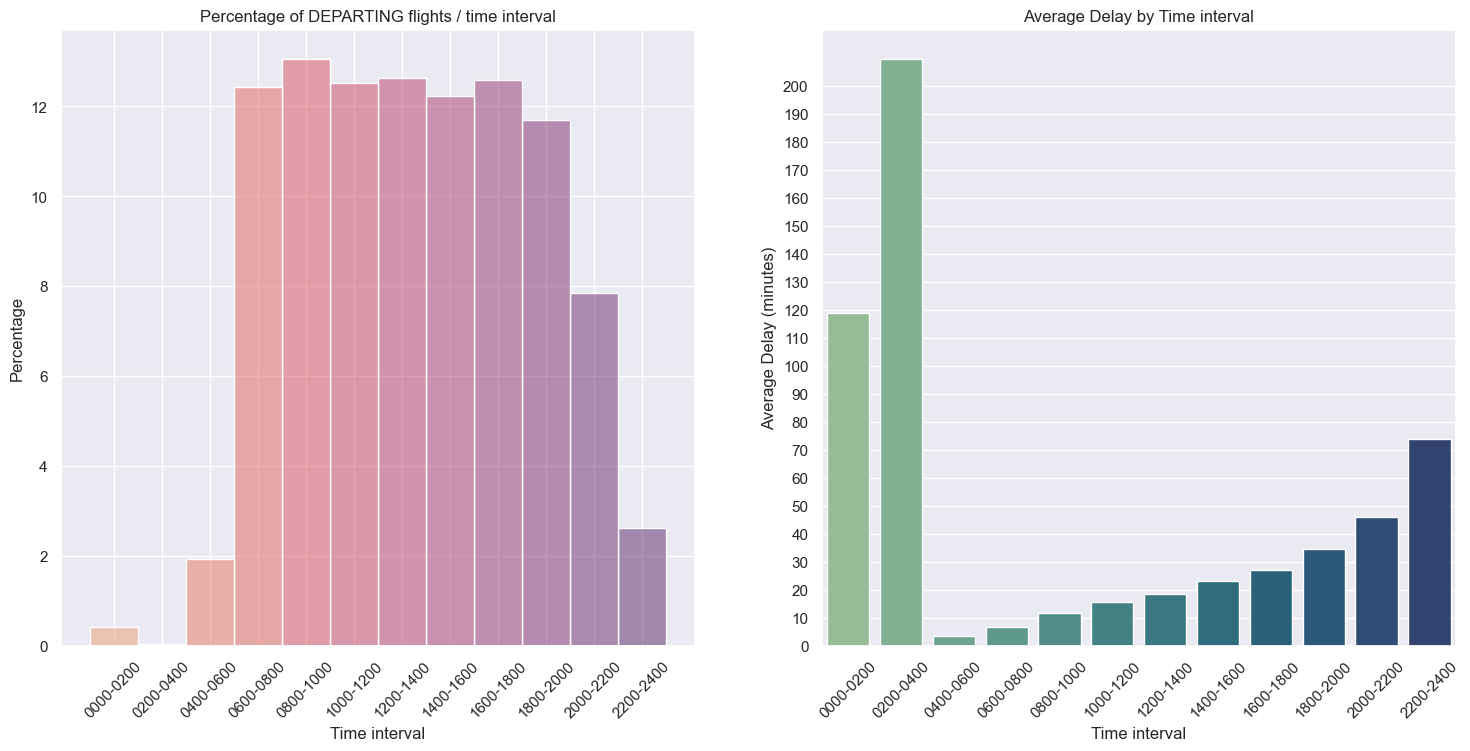

Top 3 Time Intervals with the Lowest Delay:
3. 0400-0600: 3.34 minutes
4. 0600-0800: 6.69 minutes
5. 0800-1000: 11.82 minutes
---


In [102]:
dataframes = [df95, df96, df97, df98, df99, df00, df01, df02, df03, df04, df05]

years = [1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005]

def process_yearly_flight_data(year, dataframe):
    print(f"Processing data for year {year}:")
    try:
        cleaned_df = cleaner(dataframe)
        converted_df = convert_NegDelay(cleaned_df, 'ArrDelay', 'DepDelay')
        computed_df = compute_TotalDelay(converted_df)
        created_df = create_interval(computed_df)
        mean_delay = calculate_mean_delay(created_df)
        visualize_delay(created_df, mean_delay)
        print_top_delay_intervals(mean_delay)
    except ValueError as e:
        print(f"Error processing data for year {year}: {e}")
    
    print("---")
    
for year, dataframe in zip(years, dataframes):
    process_yearly_flight_data(year, dataframe)

#### Selecting Relevant Variables - Best Time of the Day

Our chosen variables will include: `DepDelay`,`ArrDelay`,`DayOfWeek` and created variable `TotalDelay`. To reduce redundancy of data, we will focus our efforts on flights leaving their respective airports and as such we will not be including `ArrTime` nor looking at flight information for planes arriving at their destination.

For every yearly dataset, this will be the breakdown as to what we will be looking to do to the data:

Firstly we will be ***Pre-processing*** - selecting our variables, handling `NaN` values, delay values. 

Then we will move on the ***Analysis*** step - creating a daymap function which we will be using and grouping the flights into a new column. This is so we are able to visualise the distribution of flights over the week. We use a log-scale to emphasise the differences in number of flights across the week.

Finally, we then move on the ***Conclusion*** step, where we derive insights from our visualisation. 

Our pipeline for deriving the best times of the week to fly is as follows: 

   1. Run `cleaner_ii` function which removes rows with `NaN` values and converts `float64` datatypes to `int64`.
   
   2. Run `compute_NegDelay` function to convert negative delay values to 0.
   
   3. Run `compute_TotalDelay` function which sums up ArrDelay and DepDelay and returns a new column TotalDelay.
   
   4. Run `daymap` function that maps the days to the given integer in `DayOfWeek` which we will then use to find the count of flights per day. 
   
   5. Run `calculate_mean_delay_day` function which determines the mean delay for each day.
   
   6. Run `visualize_delay_day` to showcase our findings
   

In [82]:
def cleaner_ii(df):
    cleaned_df = df.loc[:, ['DayOfWeek', 'DepDelay', 'ArrDelay']]
    
#     print("Number of missing values:")
#     print(cleaned_df.isnull().sum())
    cleaned_df.dropna(inplace=True)
    
    float_columns = cleaned_df.select_dtypes(include=['float64']).columns
    cleaned_df[float_columns] = cleaned_df[float_columns].astype(int)
    
    return cleaned_df

In [83]:
def daymap(df):
    daymap = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
    df['DayOfWeek'] = df['DayOfWeek'].map(daymap)
    df['DayOfWeek'] = pd.Categorical(df['DayOfWeek'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
    
    return df

In [84]:
def calculate_mean_delay_day(df):
    mean_delay = df.groupby('DayOfWeek')['TotalDelay'].mean().reset_index()
    
    return mean_delay

In [97]:
def visualize_delay_day(df, mean_delay):
    max_delay = mean_delay['TotalDelay'].max()
    flight_counts = df['DayOfWeek'].value_counts().reset_index()
    flight_counts.columns = ['DayOfWeek', 'FlightCount']
     
    fig, ax = plt.subplots(1, 2, figsize=(18, 8))
    
    

    sns.barplot(flight_counts,  x='DayOfWeek', y='FlightCount', ax=ax[0], palette='viridis', log=True)
    ax[0].set_title('Distribution of Flights Across Days of the Week (Logarithmic Scale)')
    ax[0].tick_params(axis='x', rotation=45)
    ax[0].set_xlabel('Day of Week', rotation=0)
    ax[0].set_ylabel('Count of Flights (log scale)')

    sns.barplot(mean_delay, x='DayOfWeek', y='TotalDelay', palette='OrRd', errorbar=None, ax=ax[1])
    ax[1].set_title('Average Delay by Time interval')
    ax[1].tick_params(axis='x', rotation=45)
    ax[1].set_yticks(range(0, int(max_delay), 3))
    ax[1].set_xlabel('Time interval', rotation=0)
    ax[1].set_ylabel('Average Delay (minutes)')
    
    sns.set_style("darkgrid")
    
    plt.show()

In [98]:
def print_lowest_delay_day(mean_delay):
    mean_delay_sorted = mean_delay.sort_values(by=['TotalDelay'], ascending=True)
    lowest_days = mean_delay_sorted.head(3)
    
    print("Top 3 Days with the Lowest Delay:")
    for index, row in lowest_days.iterrows():
        interval = row['DayOfWeek']
        delay = row['TotalDelay']
        print(f"{index + 1}. {interval}: {delay:.2f} minutes")

Processing data for year 1995:


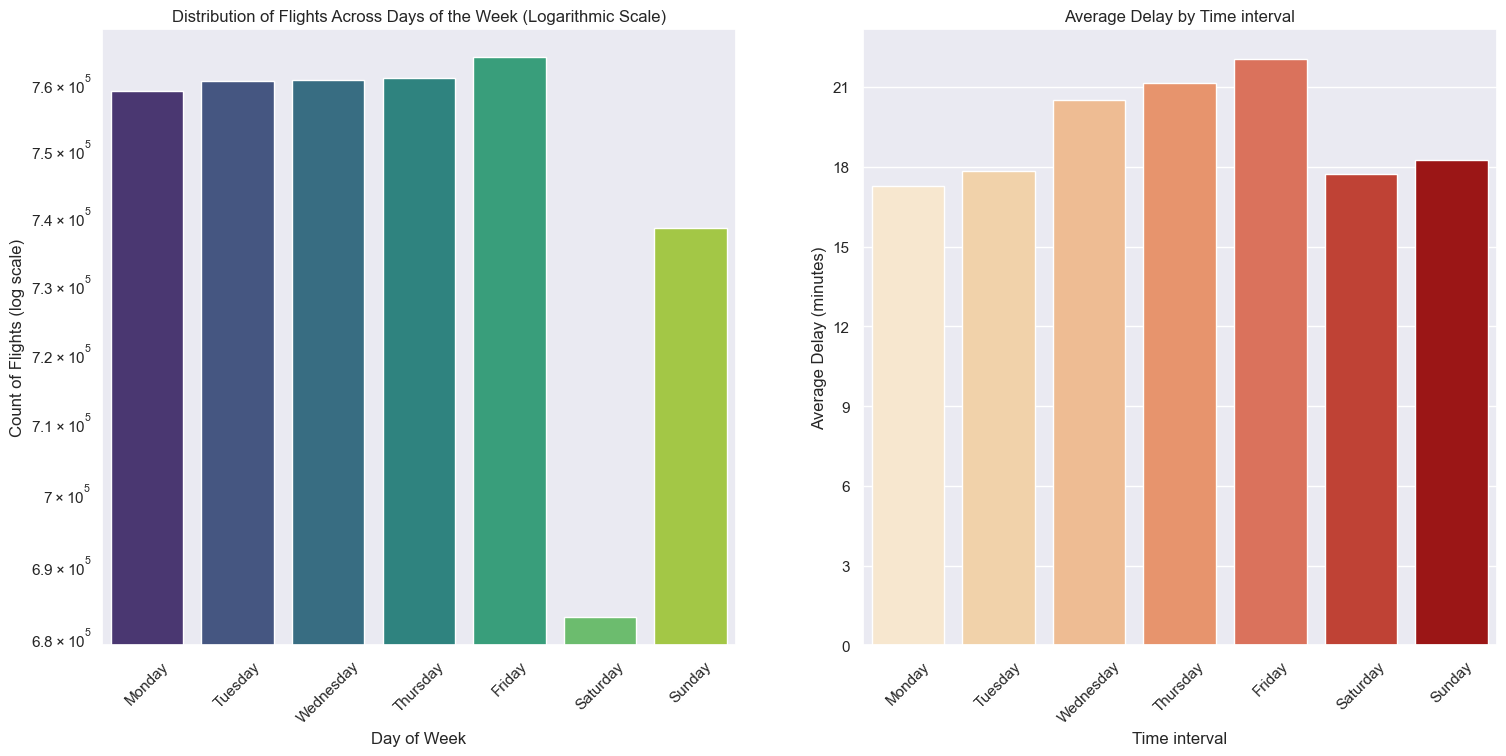

Top 3 Days with the Lowest Delay:
1. Monday: 17.28 minutes
6. Saturday: 17.74 minutes
2. Tuesday: 17.84 minutes
---
Processing data for year 1996:


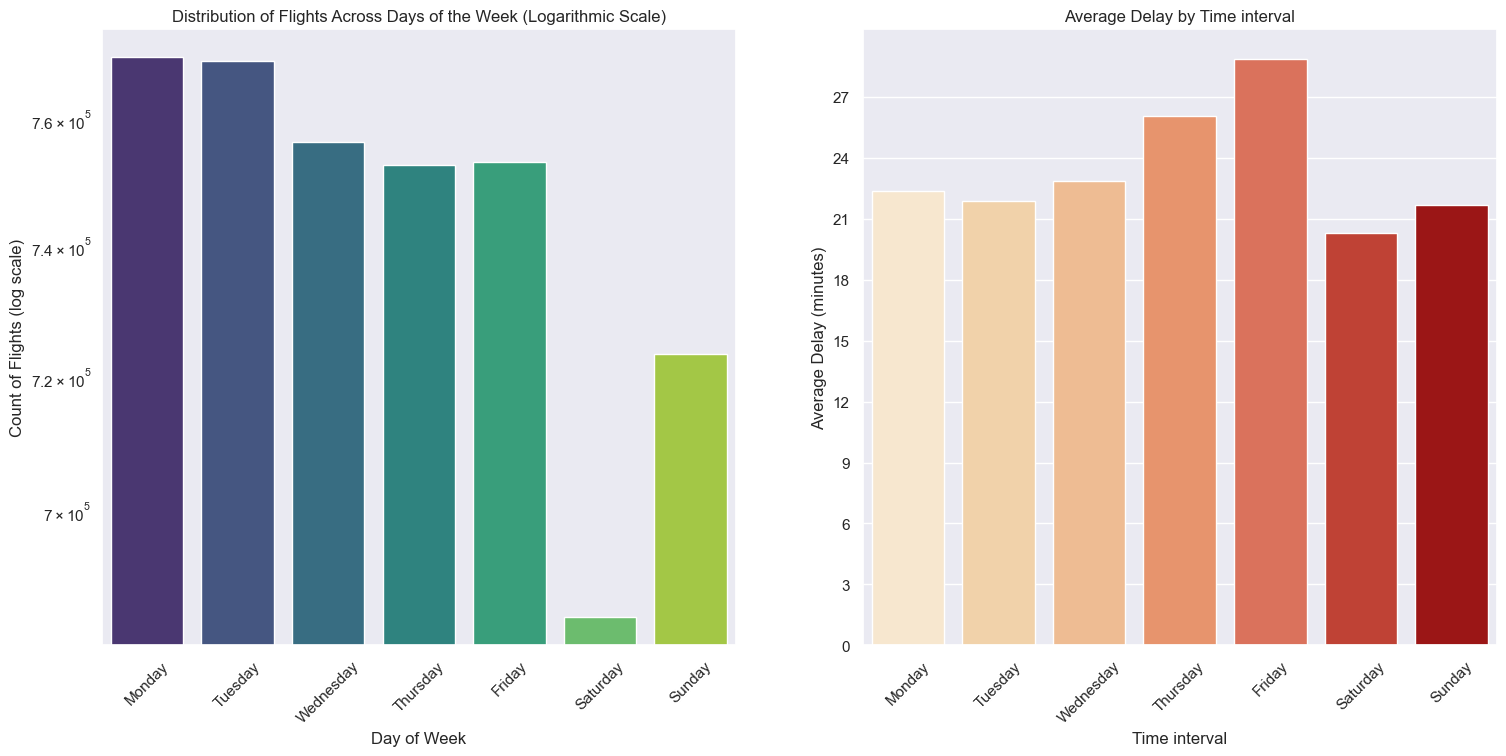

Top 3 Days with the Lowest Delay:
6. Saturday: 20.30 minutes
7. Sunday: 21.66 minutes
2. Tuesday: 21.89 minutes
---
Processing data for year 1997:


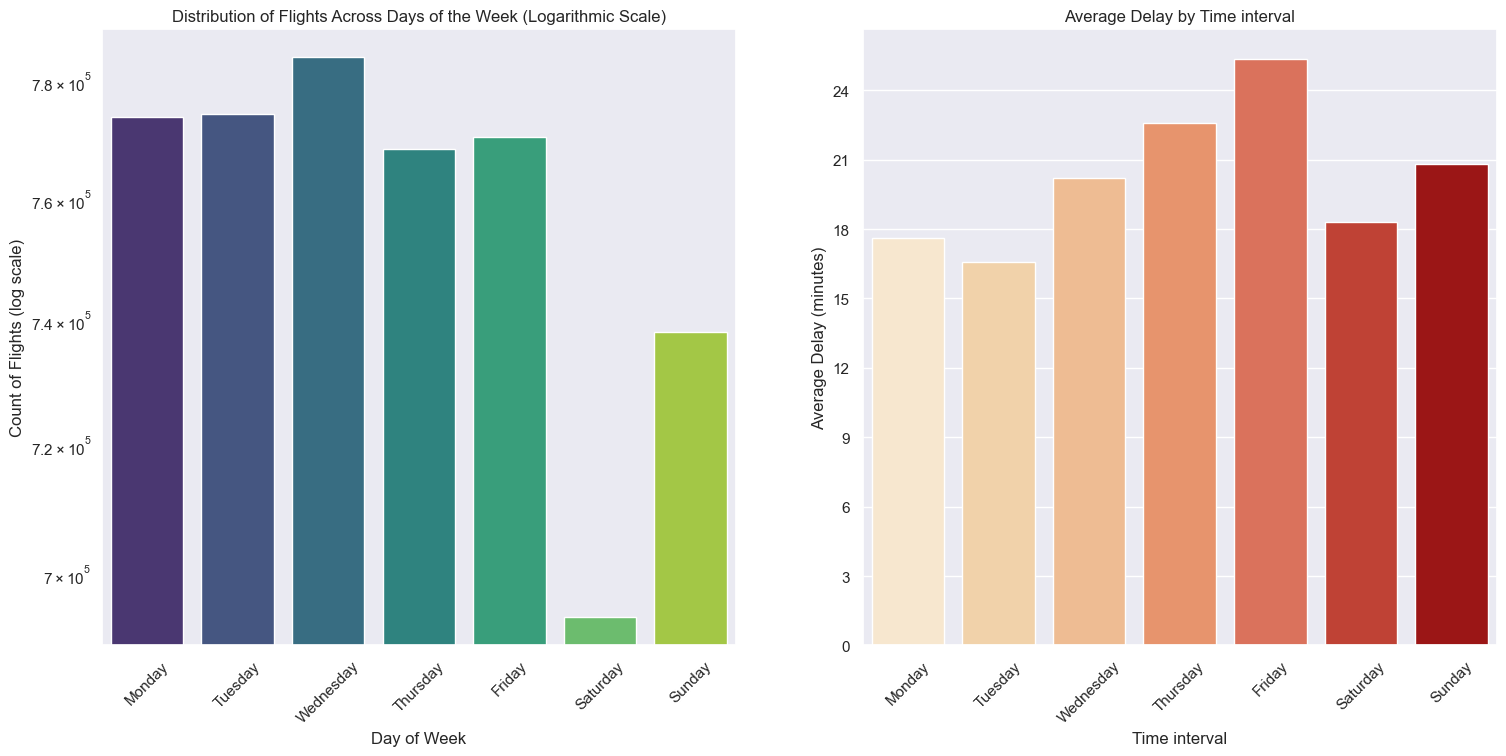

Top 3 Days with the Lowest Delay:
2. Tuesday: 16.57 minutes
1. Monday: 17.60 minutes
6. Saturday: 18.32 minutes
---
Processing data for year 1998:


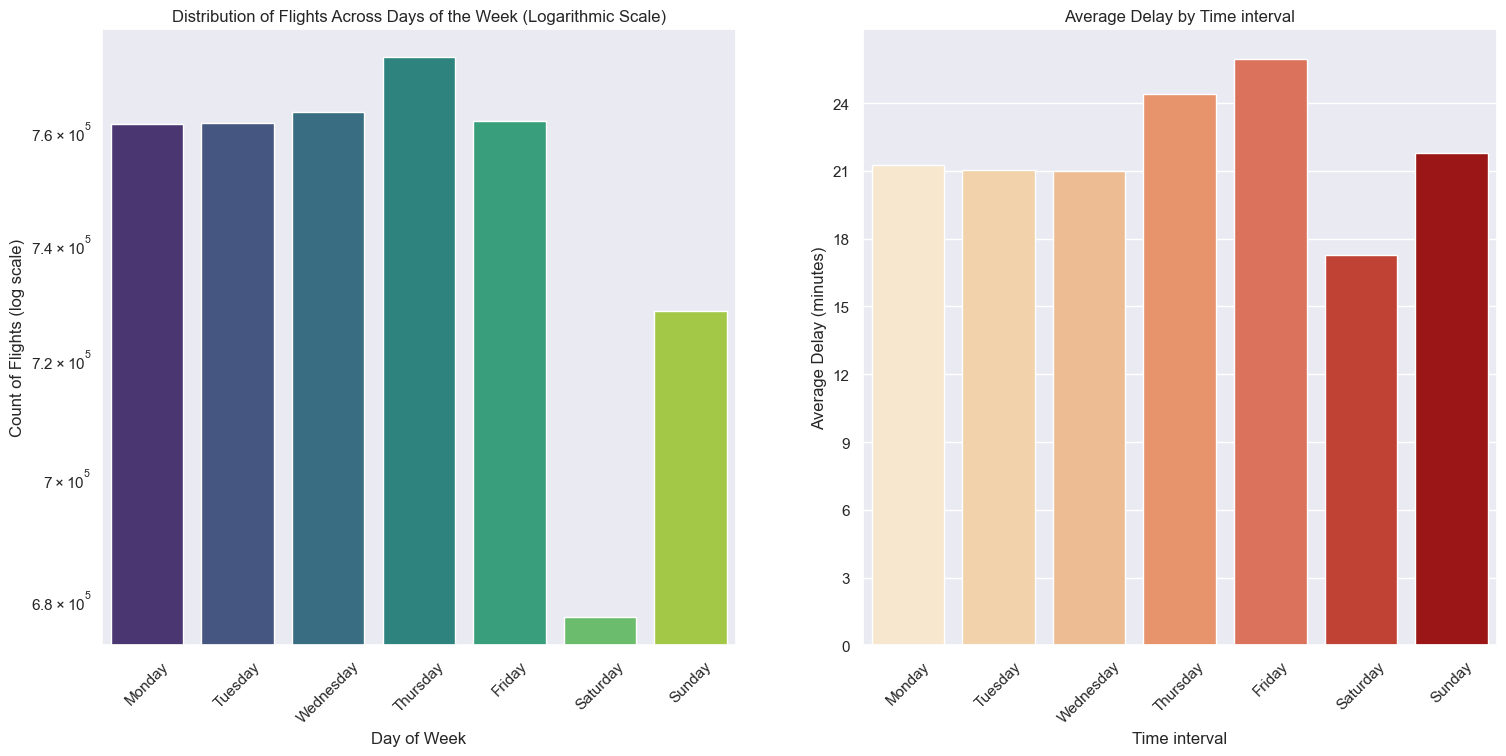

Top 3 Days with the Lowest Delay:
6. Saturday: 17.26 minutes
3. Wednesday: 21.01 minutes
2. Tuesday: 21.06 minutes
---
Processing data for year 1999:


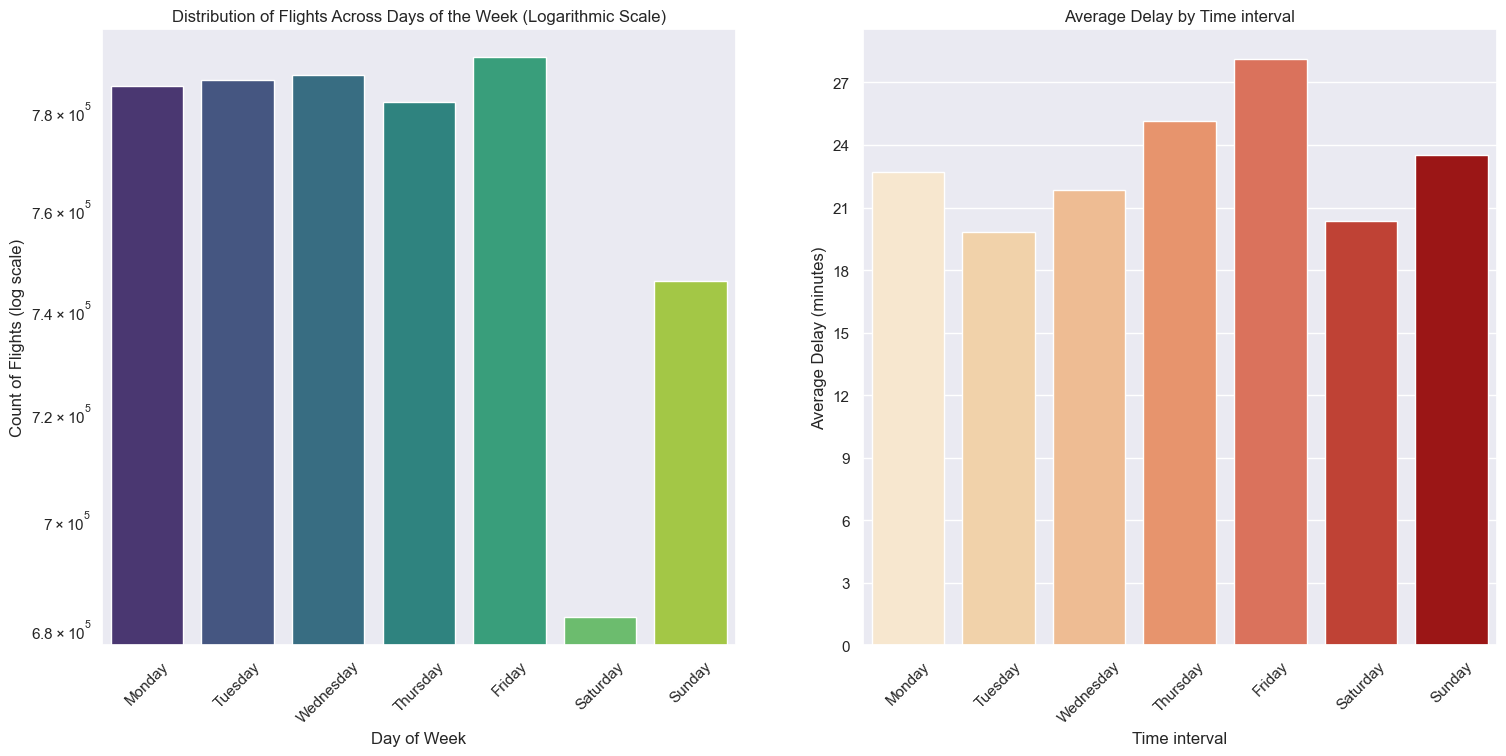

Top 3 Days with the Lowest Delay:
2. Tuesday: 19.83 minutes
6. Saturday: 20.35 minutes
3. Wednesday: 21.82 minutes
---
Processing data for year 2000:


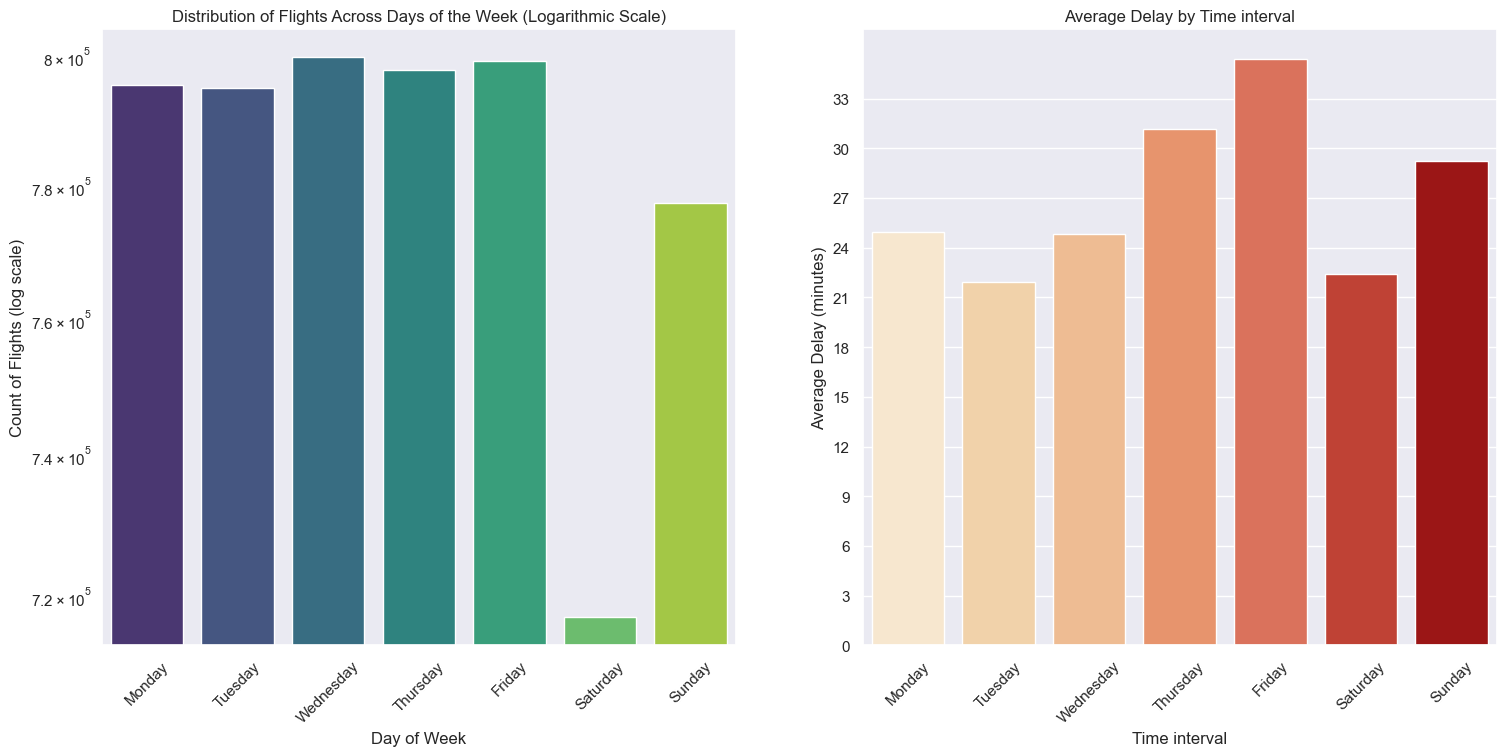

Top 3 Days with the Lowest Delay:
2. Tuesday: 21.91 minutes
6. Saturday: 22.43 minutes
3. Wednesday: 24.85 minutes
---
Processing data for year 2001:


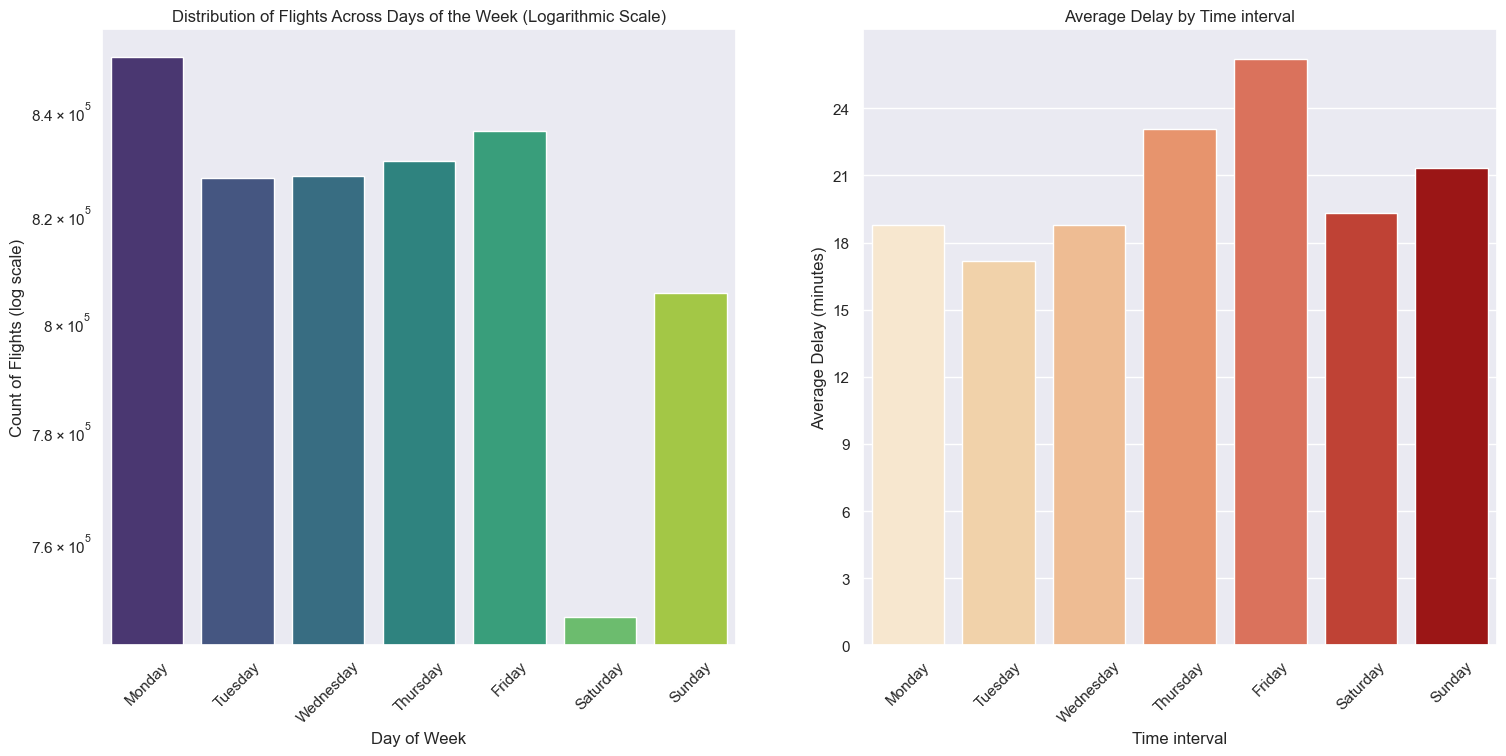

Top 3 Days with the Lowest Delay:
2. Tuesday: 17.18 minutes
1. Monday: 18.77 minutes
3. Wednesday: 18.78 minutes
---
Processing data for year 2002:


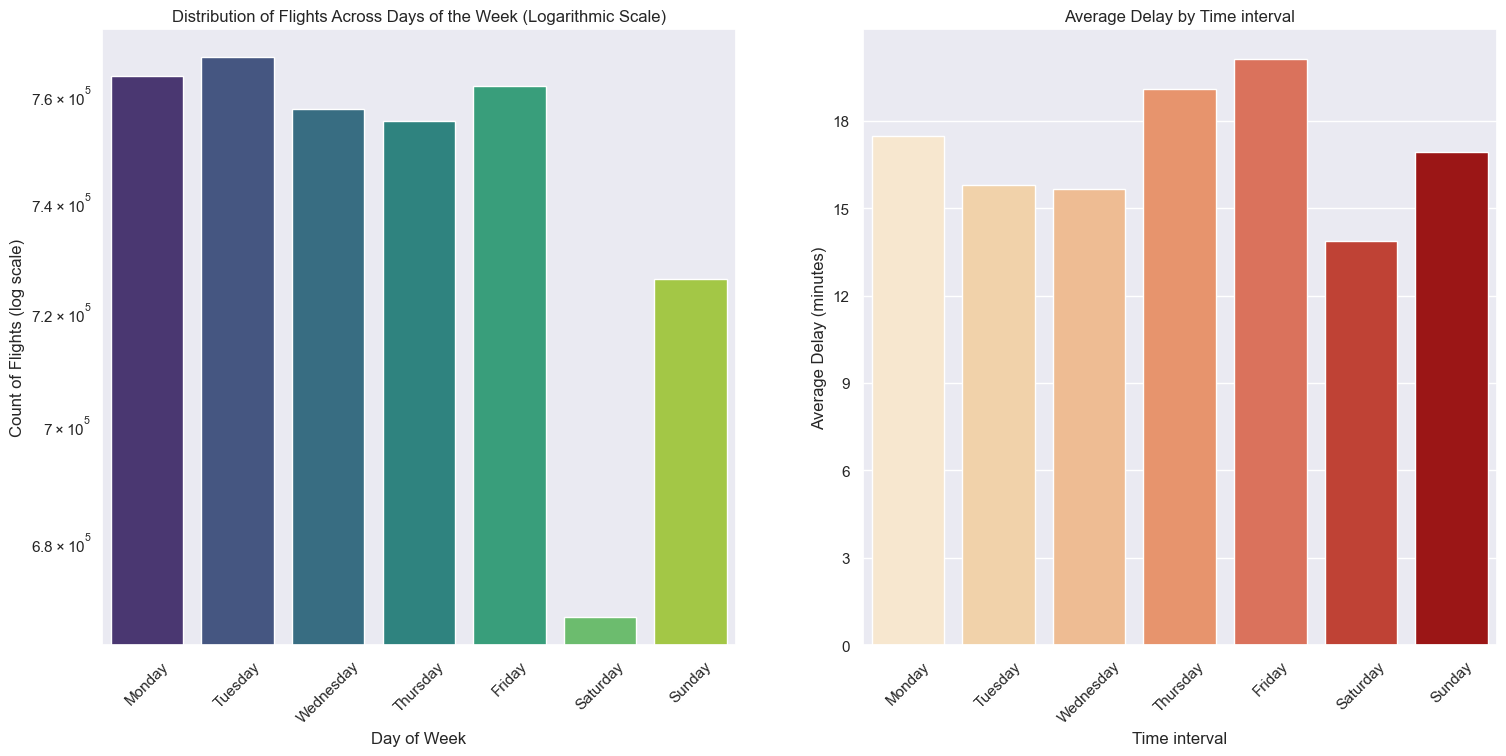

Top 3 Days with the Lowest Delay:
6. Saturday: 13.85 minutes
3. Wednesday: 15.66 minutes
2. Tuesday: 15.79 minutes
---
Processing data for year 2003:


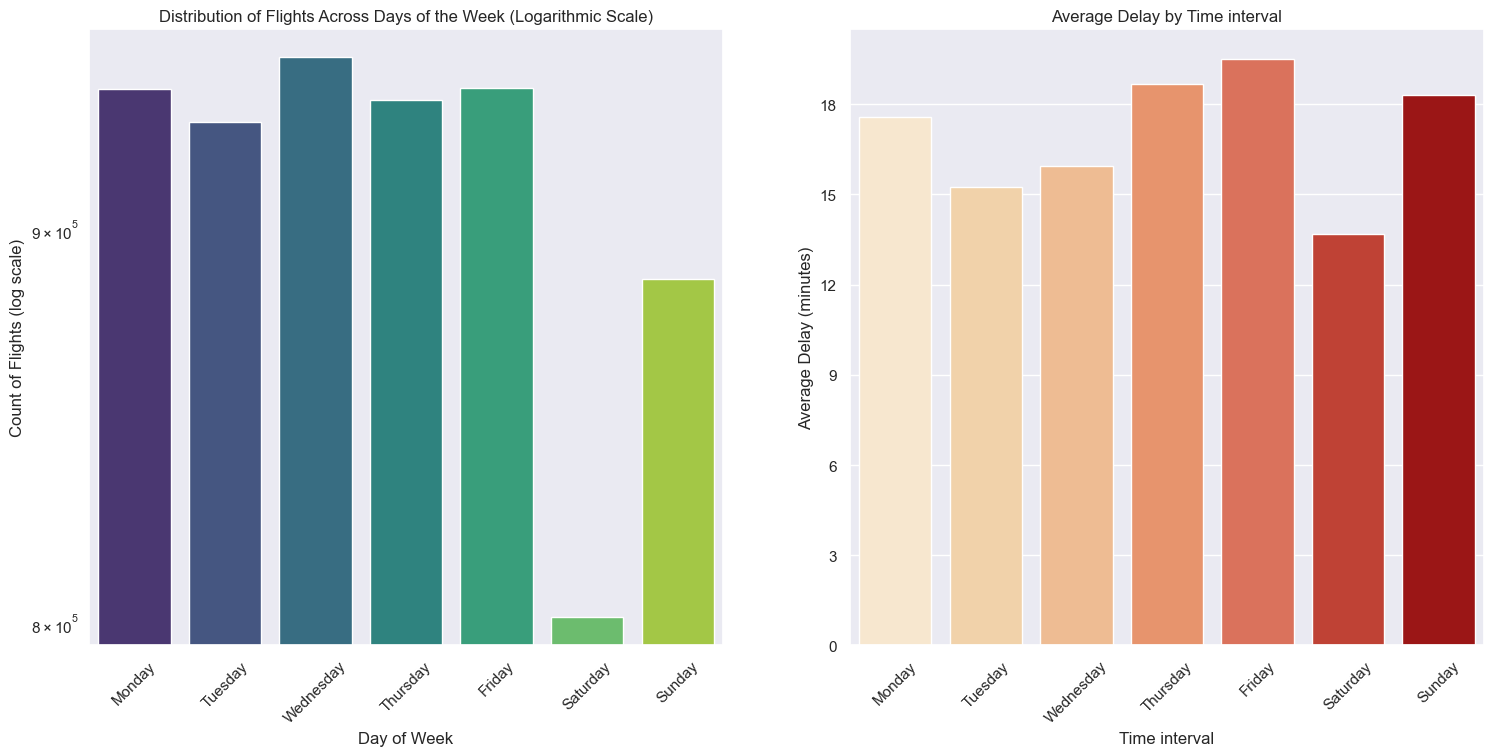

Top 3 Days with the Lowest Delay:
6. Saturday: 13.69 minutes
2. Tuesday: 15.26 minutes
3. Wednesday: 15.95 minutes
---
Processing data for year 2004:


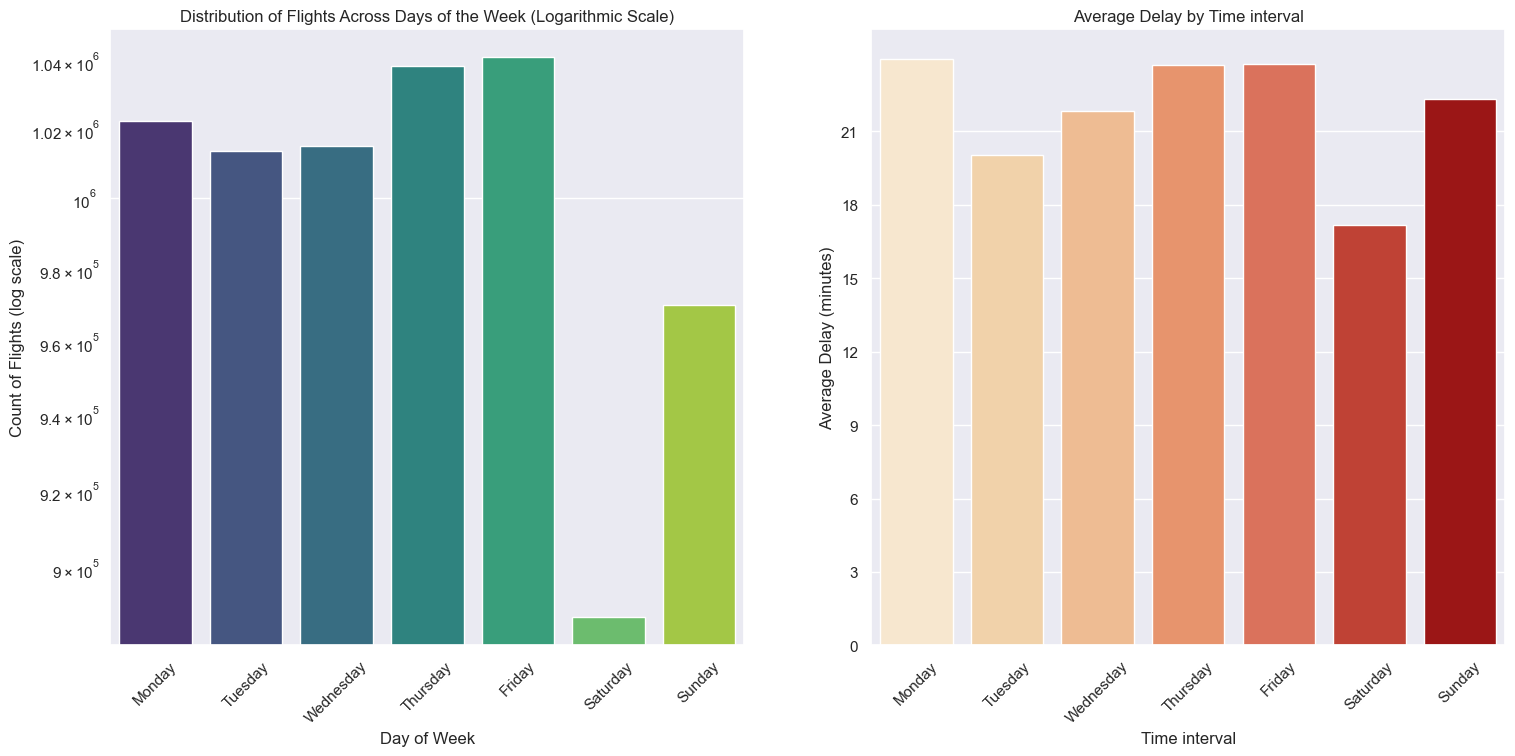

Top 3 Days with the Lowest Delay:
6. Saturday: 17.15 minutes
2. Tuesday: 20.04 minutes
3. Wednesday: 21.83 minutes
---
Processing data for year 2005:


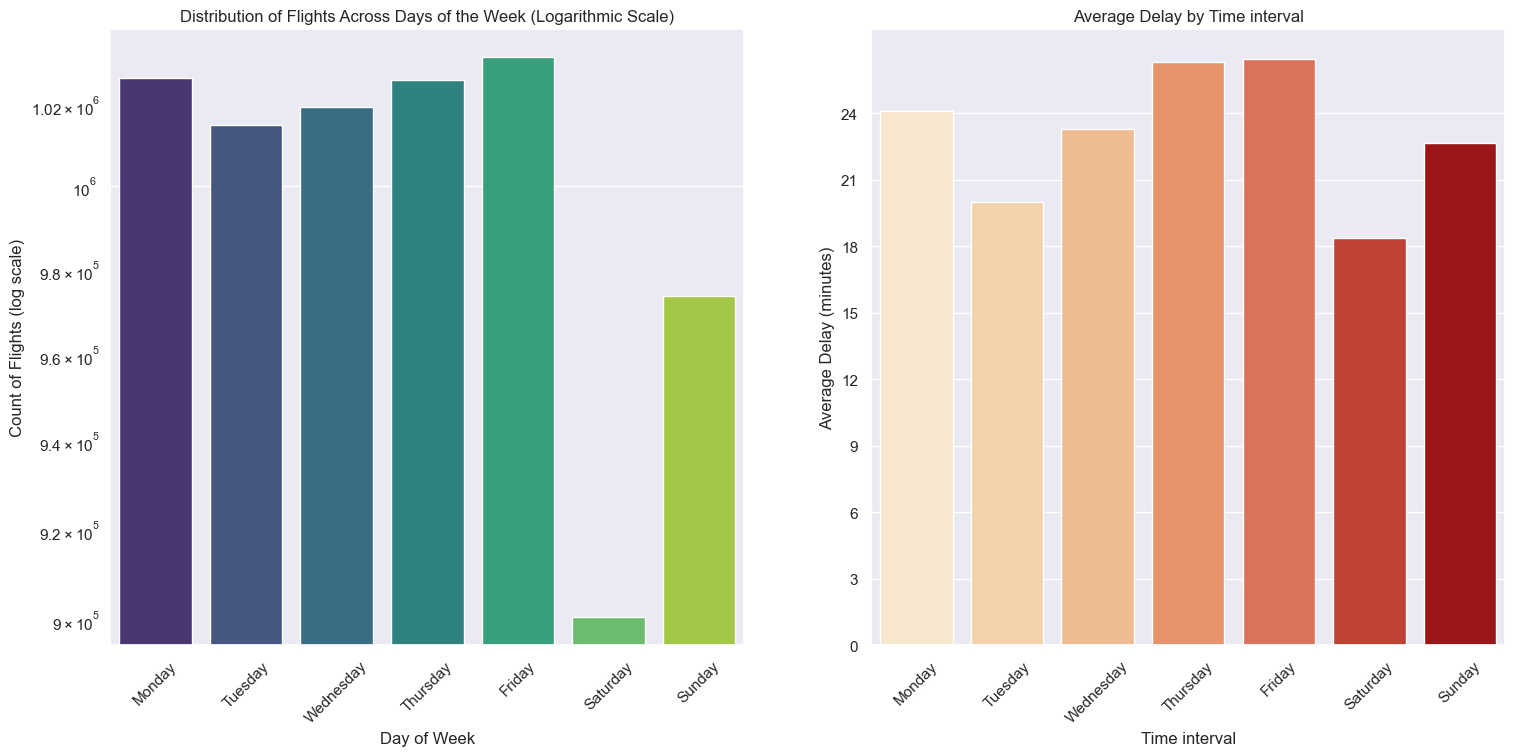

Top 3 Days with the Lowest Delay:
6. Saturday: 18.37 minutes
2. Tuesday: 20.02 minutes
7. Sunday: 22.68 minutes
---


In [99]:
def day_loop(year, dataframe):
    print(f"Processing data for year {year}:")
    try:
        cleaned_df = cleaner_ii(dataframe)
        converted_df = convert_NegDelay(cleaned_df, 'ArrDelay', 'DepDelay')
        computed_df = compute_TotalDelay(converted_df)
        mapped_df = daymap(computed_df)
        mean_delay = calculate_mean_delay_day(mapped_df)
        visualize_delay_day(mapped_df, mean_delay)
        print_lowest_delay_day(mean_delay)
    except ValueError as e:
        print(f"Error processing data for year {year}: {e}")
    
    print("---")
    
for year, dataframe in zip(years, dataframes):
    day_loop(year, dataframe)